In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 782 ms


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text angles is 0.0
Text line delta is 9
Wall time: 239 ms


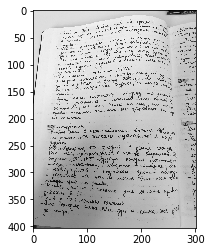

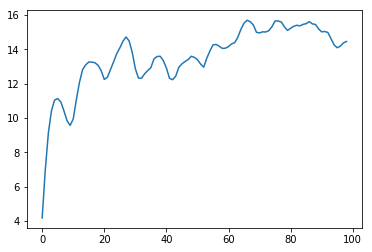

In [3]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 60.1 ms


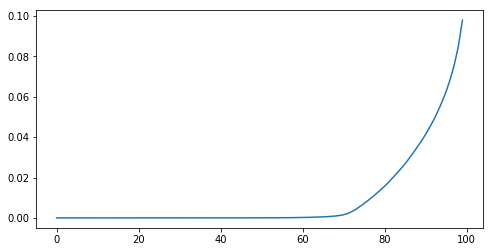

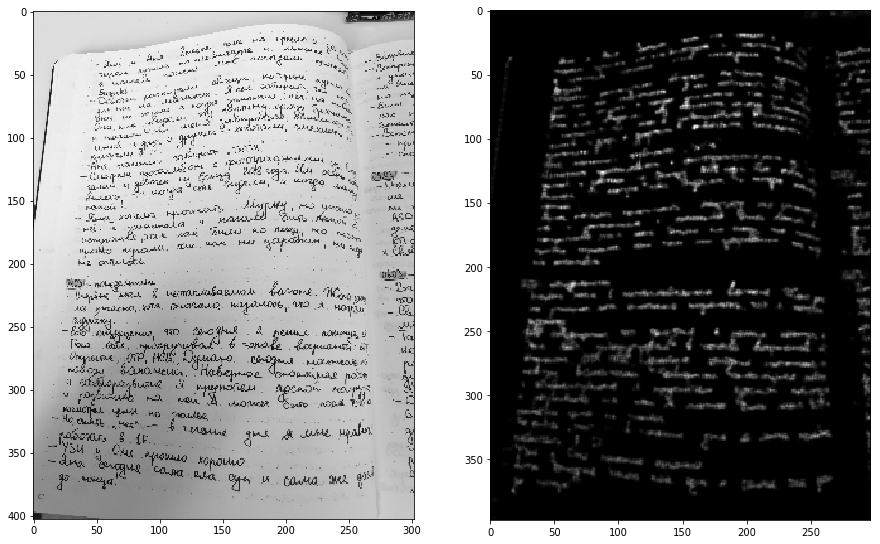

In [4]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 100 ms


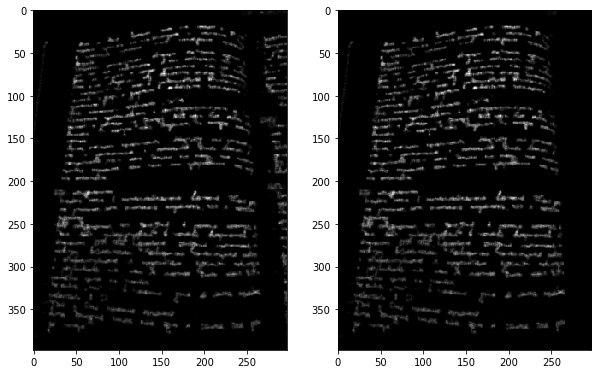

In [5]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 982 ms


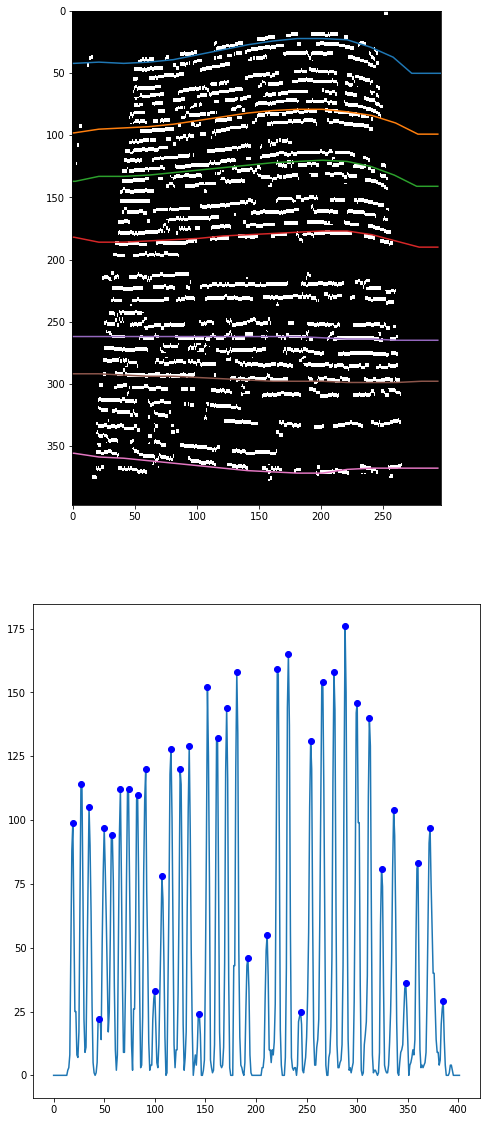

In [6]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')

Wall time: 54.1 ms


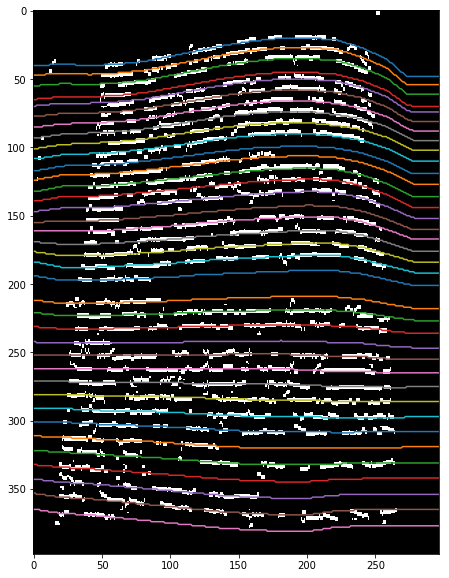

In [7]:
%%time
plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')
all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
        all_curves.append((tmp_j, tmp_i))
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
        all_curves.append((tmp_j, tmp_i))
    plt.plot(tmp_j, tmp_i)
    #print(type(imeta[i][0]))

In [78]:
def calc_cumulative_integral_with_offset(src, curve_j, curve_i, offsets):
    return np.array([np.cumsum(src[np.minimum(src.shape[0]-1, np.maximum(0, curve_i+offset)), curve_j]) for offset in offsets])

def ascend_offset(arr1d, i):
    if arr1d[i-1] < arr1d[i] and arr1d[i+1] < arr1d[i]:
        return i
    if arr1d[i-1] >= arr1d[i] and arr1d[i+1] >= arr1d[i]:
        if arr1d[i-1]>arr1d[i+1]:
            adir = arr1d[:(i+1)][::-1]
            ddir = -1
        else:
            adir = arr1d[i:]
            ddir = +1
    elif arr1d[i-1] > arr1d[i]:
        adir = arr1d[:(i+1)][::-1]
        ddir = -1
    else:
        adir = arr1d[i:]
        ddir = +1
    off = np.argmin(adir[1:]>adir[:-1])
    return i + off*ddir

def calc_offsets_by_midpoint(arr2d, i0, i1, offset, min_window):
    integral_value = arr2d[-1,offset]-arr2d[0,offset]
    if arr2d.shape[0] < min_window:
        return (i0, i1, offset, integral_value)
    
    midpoint = arr2d.shape[0] // 2
    arr_l = arr2d[midpoint,:] - arr2d[0,:]
    arr_r = arr2d[-1,:] - arr2d[midpoint,:]
    off_l = ascend_offset(arr_l, offset)
    off_r = ascend_offset(arr_r, offset)
    return (i0, i1, offset, integral_value, 
            calc_offsets_by_midpoint(arr2d[:midpoint], i0, i0+midpoint, off_l, min_window),
            calc_offsets_by_midpoint(arr2d[midpoint:], i0+midpoint, i1, off_r, min_window))

def convert_tree_to_linear(offset_tree):
    if offset_tree is None or offset_tree[3] <= 0.0:
        return [], (np.inf, -np.inf)
    if len(offset_tree) == 4:
        return [((offset_tree[0]+offset_tree[1])*0.5, offset_tree[2])], (offset_tree[0], offset_tree[1])
    
    l_part, l_mm = convert_tree_to_linear(offset_tree[4])
    r_part, r_mm = convert_tree_to_linear(offset_tree[5])
    
    f_mm = (np.min([l_mm[0], r_mm[0]]), np.max([l_mm[1], r_mm[1]]))    
    return l_part+r_part, f_mm

def optimize_curve(src, crv_j, crv_i, offset, min_window):
    loc_arr2d = calc_cumulative_integral_with_offset(src, crv_j, crv_i, np.arange(-offset, offset+1)).T
    tree_off = calc_offsets_by_midpoint(loc_arr2d, 0, loc_arr2d.shape[0], offset, min_window)
    off_ji, off_mm = convert_tree_to_linear(tree_off)
    off_ji_np = np.array(off_ji)
    off_min = max(0, int(off_mm[0])-3)
    off_max = min(src.shape[1], int(off_mm[1])+3)
    new_j = crv_j[off_min:off_max]
    new_i_full = np.minimum(src.shape[0]-1, np.maximum(0, np.round(crv_i + np.interp(crv_j, off_ji_np[:,0], off_ji_np[:,1]) - offset))).astype(int)
    return new_j, new_i_full[off_min:off_max]

5

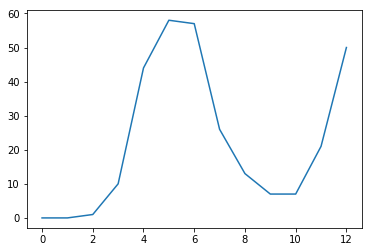

In [9]:
tmp_offsets = np.arange(-6, 7)
tmp1 = calc_cumulative_integral_with_offset(src8, all_curves[4][0], all_curves[4][1], tmp_offsets).T
midpoint = (src8.shape[1]-1)//2
tmp21 = tmp1[midpoint,:]
tmp22 = tmp1[-1,:]-tmp1[midpoint,:]
plt.plot(tmp22)
#calc_closest_local_maxima(tmp2, 10)
ascend_offset(tmp22, 6)

Wall time: 135 ms


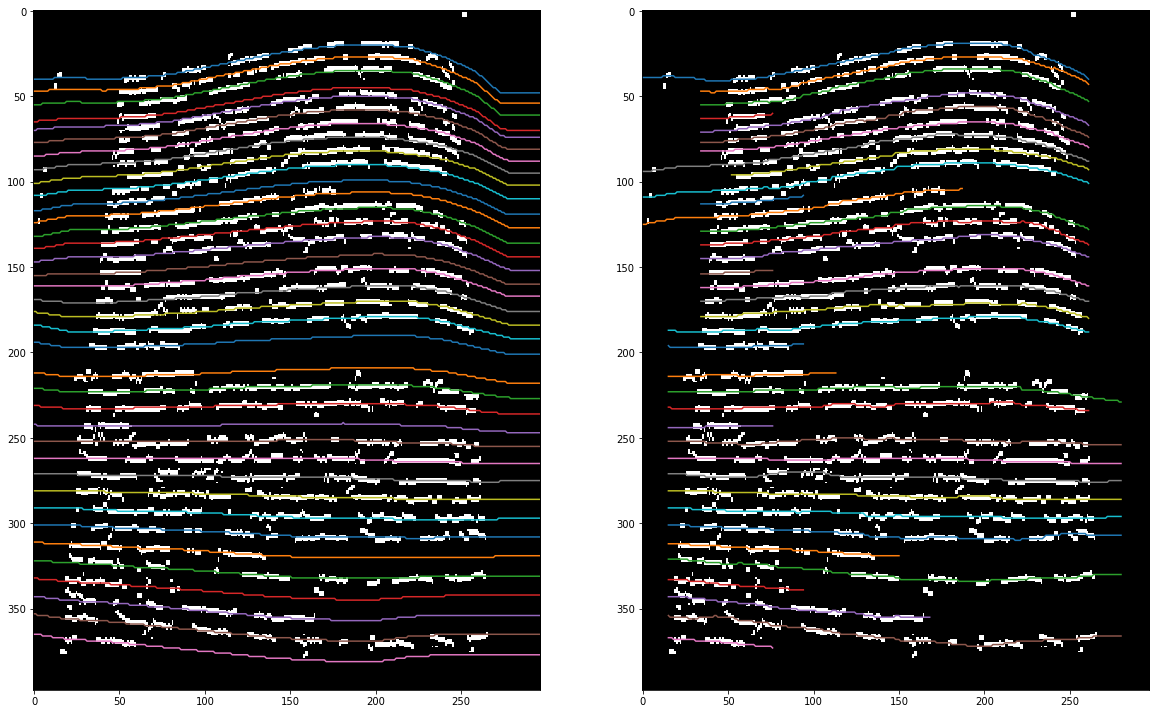

In [84]:
%%time
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(src8, cmap='gray')
for curve in all_curves:
    plt.plot(curve[0], curve[1])

plt.subplot(122)
plt.imshow(src8, cmap='gray')
for curve in all_curves:
    true_j, true_i = optimize_curve(src8, curve[0], curve[1], offset=4, min_window=20)
    plt.plot(true_j, true_i)

In [46]:
optimize_curve(src8, all_curves[3][0], all_curves[3][1], 3, min_window=20, min_pct_value=0.05)

(array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73]),
 array([63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 61, 61, 61, 61, 61,
        61, 61, 61]))